In [1]:
import numpy as np
from dataclasses import dataclass
from matplotlib import pyplot as plt

Vector = np.ndarray
Vector2D = np.ndarray
Angle = float
Point3Ds = np.ndarray  # (3xn)
Point2Ds = np.ndarray  # (2xn)


def rz(alpha):
    a = alpha
    c = np.cos
    s = np.sin
    return np.array([
        [c(a), -s(a), 0],
        [s(a),  c(a), 0],
        [0, 0,  1]
    ])


def ry(beta):
    a = beta
    c = np.cos
    s = np.sin
    return np.array([
        [c(a), 0, s(a)],
        [0,  1, 0],
        [-s(a), 0,  c(a)]
    ])


def rx(gamma):
    a = gamma
    c = np.cos
    s = np.sin
    return np.array([
        [1, 0, 0],
        [0, c(a), -s(a)],
        [0, s(a),  c(a)]
    ])


def R_rad(alpha, beta, gamma):
    return rz(alpha) @ ry(beta) @ rx(gamma)


def R_deg(alpha_deg, beta_deg, gamma_deg):
    return R_rad(alpha=np.radians(alpha_deg),
                 beta=np.radians(beta_deg),
                 gamma=np.radians(gamma_deg))


def vec(x):
    return np.array([[t] for t in x])


def x_hat():
    return vec([1, 0, 0])


def y_hat():
    return vec([0, 1, 0])


def z_hat():
    return vec([0, 0, 1])


def line(x0: Vector, u: Vector, t_min=0, t_max=1, n_points=20):
    u = np.array(u)
    ret = np.zeros((len(u), n_points))
    for i, t in enumerate(np.linspace(t_min, t_max, n_points)):
        ret[:, [i]] = x0+u*t
    return ret


def make_plane(o, u, v, tu=(0, 5), tv=(0, 5), nu=6, nv=6):
    ret = []
    for iu in np.linspace(tu[0], tu[1], nu):
        ret.append(line(o+iu*u, v, t_min=tv[0], t_max=tv[1]))

    for iv in np.linspace(tv[0], tv[1], nv):
        ret.append(line(o+iv*v, u, t_min=tu[0], t_max=tu[1]))
        
    return np.hstack(ret)


ORIGIN = vec([0, 0, 0])

In [2]:
def line_from_to(x0: Vector, u: Vector, t_min=0, t_max=1, n_points=100):
    u = np.array(u)
    ret = np.zeros((len(u), n_points))
    # print(ret.shape)
    for i, t in enumerate(np.linspace(t_min, t_max, n_points)):
        ret[:, i] = x0+u*t
    return ret


def make_x_axis(length=5) -> Point2Ds:
    return line(ORIGIN, x_hat(), 0, length)


def make_y_axis(length=5) -> Point2Ds:
    return line(ORIGIN, y_hat(), 0, length)


def make_z_axis(length=5) -> Point2Ds:
    return line(ORIGIN, z_hat(), 0, length)


@dataclass
class Camera:
    # t is defined as where the world origin is from camera frame view
    # and -alpha -beta -gamma is the description of world axis from camera frame view
    t: Vector
    alpha: Angle
    beta: Angle
    gamma: Angle
    f_prime: float
    c: Vector2D

    @property
    def R(self):
        return R_rad(self.alpha, self.beta, self.gamma)
        
        
    def project(self, x_w: Point3Ds) -> Point2Ds:
        s = self
        x_c = s.R @ x_w + s.t
        z_c = x_c[2, :]        
        u = x_c/z_c*s.f_prime + s.c
        return u[0:2, :]
    
    def unproject_to_xz(self, u: Point2Ds) -> Point3Ds:
        s = self
        u = np.vstack([u, [s.f_prime]*u.shape[1]]) # do sth better
        
        c = vec([s.c[0,0], s.c[1,0], 0.])
        #print(c)
        #print(u-c)
        num = y_hat().T @ (s.R.T @ s.t) #####<<< fix the note the sign was wrong
        denom = y_hat().T @ s.R.T @ (u-c)
        k = num/denom
        
        x_w = s.R.T @ (k * (u-c) - s.t) #####<< fix the note the sign was wrong
        return x_w
    
#     def M(self): # for perspective transform from u,v -> x, z
        
    
    @classmethod
    def standard(cls) -> 'Camera':
        return Camera(
            t=vec([0, -10, 20]),
            alpha=np.radians(0),
            beta=np.radians(0),
            gamma=np.radians(-15),
            f_prime=1,
            c=vec([0, 0, 0])
        )


def visualize(points: Point2Ds, **kwds):
    plt.plot(points[0, :], points[1, :], **kwds)
    


(3, 240)


(-1.0, 1.0)

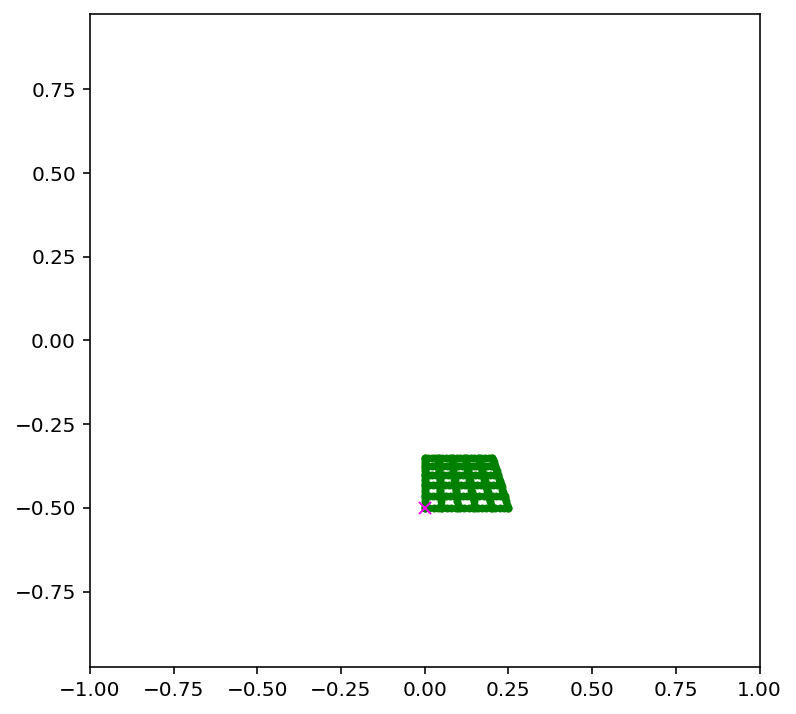

In [3]:
cm = Camera.standard()
x_axis = make_x_axis()
y_axis = make_y_axis()
z_axis = make_z_axis()

x_z_plane = make_plane(ORIGIN, x_hat(), z_hat())
print(x_z_plane.shape)
x_y_plane = make_plane(ORIGIN, x_hat(), y_hat())
y_z_plane = make_plane(ORIGIN, y_hat(), z_hat())

plt.figure(figsize=(6,6))
# visualize(cm.project(x_axis), color='red')
# visualize(cm.project(y_axis), color='blue')
# visualize(cm.project(z_axis), color='green')
visualize(cm.project(x_z_plane), color='green', marker='.', linestyle='')
#visualize(cm.project(x_y_plane), color='red', marker='.', linestyle='')
#visualize(cm.project(y_z_plane), color='blue', marker='.', linestyle='')
visualize(cm.project(ORIGIN), color='magenta', marker='x', linestyle='')
plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)

## Unproject

todo make it more generic

In [4]:
cm = Camera.standard()
sample_points = np.array([[x, 0., z] for x in np.arange(0,5) for z in range(0, 5)]).T
u = cm.project(sample_points)

cm.unproject_to_xz(u)

print(sample_points)
print(cm.unproject_to_xz(u))

[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4.
  4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3.
  4.]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  2.00000000e+00  2.00000000e+00
   2.00000000e+00  2.00000000e+00  2.00000000e+00  3.00000000e+00
   3.00000000e+00  3.00000000e+00  3.00000000e+00  3.00000000e+00
   4.00000000e+00  4.00000000e+00  4.00000000e+00  4.00000000e+00
   4.00000000e+00]
 [ 0.00000000e+00 -1.13797860e-15  2.77555756e-16  7.77156117e-16
  -3.33066907e-16  0.00000000e+00 -1.13797860e-15  2.77555756e-16
   7.77156117e-16 -3.33066907e-16  0.00000000e+00 -1.13797860e-15
   2.77555756e-16  7.77156117e-16 -3.33066907e-16  0.00000000e+00
  -1.13797860e-15  2.77555756e-16  7.77156117e-16 -3.33066907e-16
   0.00000000e

## Figure out camera angle from u,v and actual samples

Camera(t=array([[1.44664469e-03],
       [1.37537723e+00],
       [1.21956792e+01]]), alpha=-1.5204555486305607e-05, beta=7.316286467540234e-05, gamma=-0.9410813007210544, f_prime=0.6097623702038492, c=array([[-7.03320451e-05],
       [-5.68765302e-01],
       [ 0.00000000e+00]]))
Camera(t=array([[  0],
       [-10],
       [ 20]]), alpha=0.0, beta=0.0, gamma=-0.2617993877991494, f_prime=1, c=array([[0],
       [0],
       [0]]))


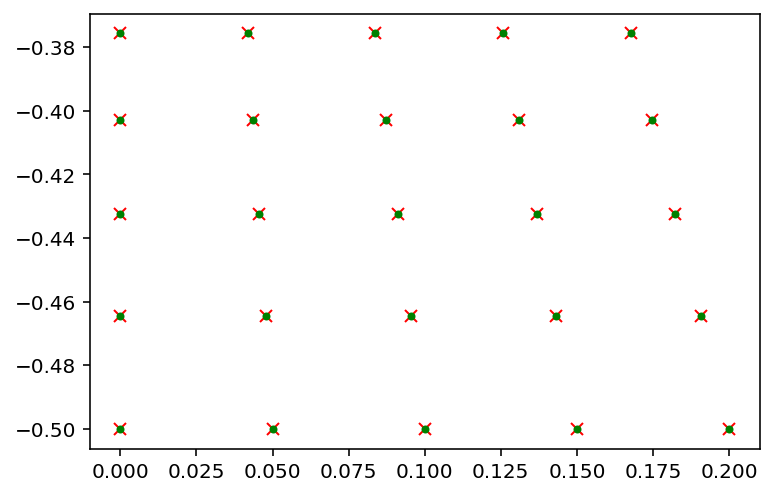

In [5]:
from scipy.optimize import minimize
cm = Camera.standard()
sample_points = np.array([[x, 0., z] for x in np.arange(0,5) for z in range(0, 5)]).T
u = cm.project(sample_points)


def cost(v): #looks like cx and cy is important for disambiguity?? # but looks like they really map-demap to the same thing
    tx, ty, tz, alpha, beta, gamma, f_prime, cx, cy = v
    cm = Camera(t = vec([tx, ty, tz]), alpha=alpha, beta=beta, gamma=gamma, f_prime=f_prime, c= vec([cx, cy, 0.]))
    got = cm.project(sample_points)
    diff = np.sum((u-got)**2)
    return diff

res = minimize(cost, [0,0,3, 0,0,0, 1., 0,0])

tx, ty, tz, alpha, beta, gamma, f_prime, cx, cy = res.x
cm = Camera(t = vec([tx, ty, tz]), alpha=alpha, beta=beta, gamma=gamma, f_prime=f_prime, c= vec([cx, cy, 0.]))
visualize(u, color='red', marker='x', linestyle='')
visualize(cm.project(sample_points), color='green', marker='.', linestyle='')


print(cm)
print(Camera.standard())

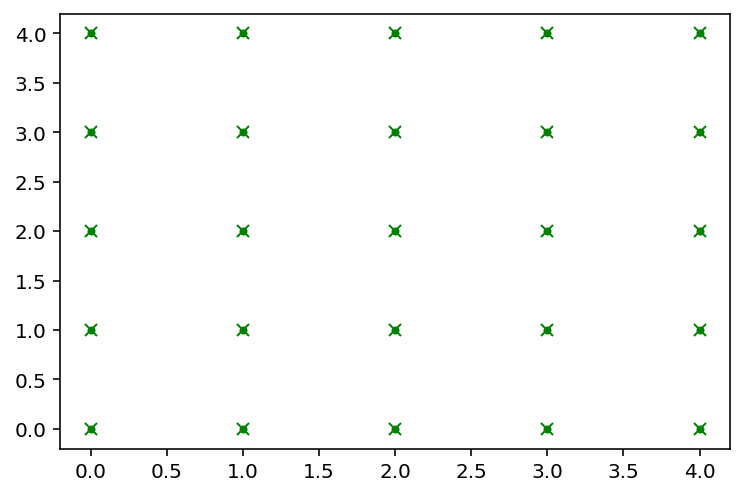

In [6]:
# now use the camera to unproject the points back --> should get grid
tx, ty, tz, alpha, beta, gamma, f_prime, cx, cy = res.x
cm = Camera(t = vec([tx, ty, tz]), alpha=alpha, beta=beta, gamma=gamma, f_prime=f_prime, c= vec([cx, cy, 0.]))
got = cm.unproject_to_xz(u)
visualize(got[[0,2],:], color='green', marker='.', linestyle='')

visualize(sample_points[[0,2],:], color='green', marker='x', linestyle='')


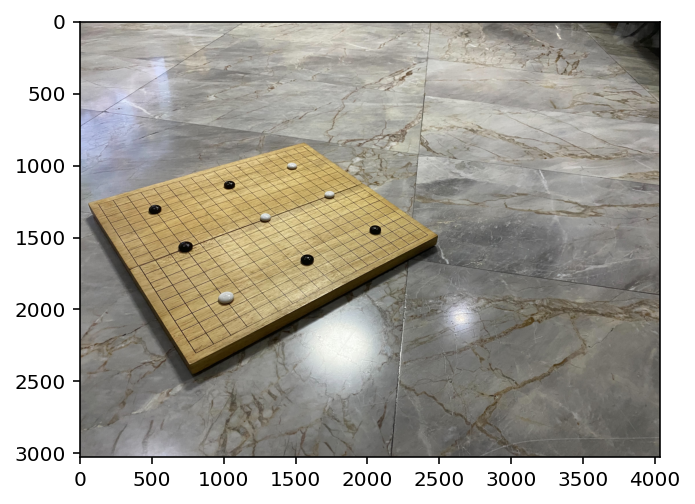

In [7]:
import cv2
im = cv2.imread('S__45367306.jpg')
#im = cv2.resize(im, None, fx=0.2, fy=0.2)
pyplotim2 = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

plt.imshow(pyplotim2)



In [8]:
from ipywidgets import interact, interactive, widgets

def show(tx, ty, tz, f, alpha, beta, gamma):
    cm = Camera.standard()
    cm.t = vec([tx, ty, tz])
    cm.alpha = np.radians(alpha)
    cm.beta = np.radians(beta)
    cm.gamma = np.radians(gamma)
    cm.f_prime = f
    visualize(cm.project(x_z_plane), color='green', marker='.', linestyle='')
    visualize(cm.project(x_y_plane), color='red', marker='.', linestyle='')
    visualize(cm.project(y_z_plane), color='blue', marker='.', linestyle='')
    visualize(cm.project(ORIGIN), color='magenta', marker='x', linestyle='')
    print(cm.project(ORIGIN))

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    #plt.axis('scaled')
    plt.grid()
    plt.show()

    
def angle_slider():
    return widgets.IntSlider(min=-180, max=180, step=1, value=0, continuous_update=False)

def pan_slider(**kwds):
    s = dict(min=-10, max=30, step=1, value=0, continuous_update=False)
    s.update(kwds)
    return widgets.IntSlider(**s)
def zoom_slider(**kwds):
    return widgets.FloatSlider(min=0.1, max=200, step=0.1, value=1, continuous_update=False)
plt.figure(figsize=(6,6))
interactive_plot = interactive(show, 
                               tx=pan_slider(),
                               ty=pan_slider(),
                               tz=pan_slider(value=10),
                               f=zoom_slider(),
                               alpha=angle_slider(), 
                               beta=angle_slider(), 
                               gamma=angle_slider())
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='tx', max=30, min=-10), IntSlide…

<Figure size 432x432 with 0 Axes>

      fun: 54.7605616156775
 hess_inv: array([[ 1.39233411e-02, -3.99987642e-03, -3.77843749e-04,
        -3.52822467e-04,  2.97795287e-05,  3.70202999e-05,
         2.81002053e-02, -1.55261627e+00, -9.50068025e-02],
       [-3.99987642e-03,  3.68613236e-03,  2.89905785e-04,
         7.87691710e-05, -5.94998207e-06, -1.19437001e-05,
        -9.11235858e-03,  3.87554123e-01, -1.03186497e-01],
       [-3.77843749e-04,  2.89905785e-04,  2.39693567e-05,
         7.87516695e-06, -5.91243965e-07, -1.05138351e-06,
        -8.38278550e-04,  3.77105264e-02, -6.09424782e-03],
       [-3.52822467e-04,  7.87691710e-05,  7.87516695e-06,
         9.27157511e-06, -7.81774142e-07, -9.36998850e-07,
        -7.02074456e-04,  3.99593114e-02,  3.49751206e-03],
       [ 2.97795287e-05, -5.94998207e-06, -5.91243965e-07,
        -7.81774142e-07,  6.76863082e-08,  7.96782815e-08,
         5.89760282e-05, -3.39159366e-03, -3.09998538e-04],
       [ 3.70202999e-05, -1.19437001e-05, -1.05138351e-06,
        -9.3

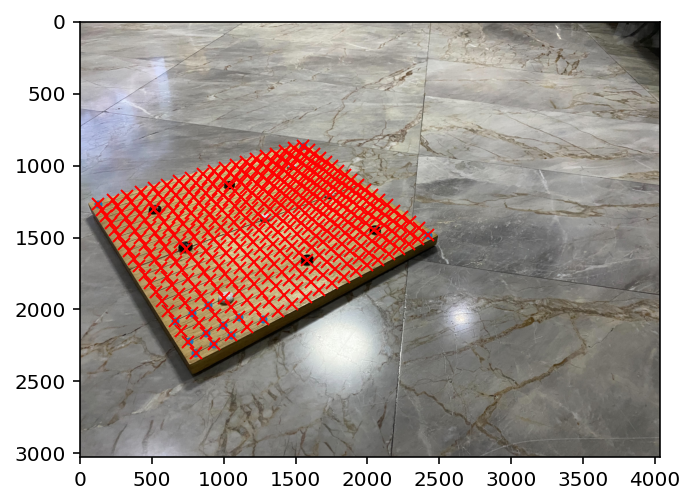

In [9]:
data = np.array([
    [0, 0, 804., 2301],
    [1, 0, 929, 2241],
    [2, 0, 1050, 2178],
    [4, 0, 1271, 2064],
    [0, 1, 756, 2222],
    [1, 1, 877, 2162],
    [2, 1, 995, 2105],
    [3, 1, 1109, 2051],
    [0, 3, 661, 2079],
    [1, 3, 777, 2025],
    [2, 3, 890, 1970],
    [18, 18, 1552, 862],
    [0, 18, 129, 1268],
    [18,0, 2418, 1480]
])
actual_x = data[:, 0]
actual_z = data[:, 1]
u = data[:, 2]
v = data[:, 3]

plt.imshow(pyplotim2)
plt.scatter(u, v, marker='.')


u = np.vstack([u, v])
samples = np.vstack([actual_x, [0.]*len(actual_x), actual_z])


def make_cost(sample_points, u):
    def cost(v):  # looks like cx and cy is important for disambiguity?? # but looks like they really map-demap to the same thing
        tx, ty, tz, alpha, beta, gamma, f_prime, cx, cy = v
        cm = Camera(t=vec([tx, ty, tz]), alpha=alpha, beta=beta,
                    gamma=gamma, f_prime=f_prime, c=vec([cx, cy, 0.]))
        got = cm.project(sample_points)
        diff = np.sum((u-got)**2)
        return diff
    return cost


cost = make_cost(samples, u)
res = minimize(cost, [0, 0, 0.1, 0, 0, 0, 100., 0., 0.])
print(res)

tx, ty, tz, alpha, beta, gamma, f_prime, cx, cy = res.x
cm = Camera(t=vec([tx, ty, tz]), alpha=alpha, beta=beta,
            gamma=gamma, f_prime=f_prime, c=vec([cx, cy, 0.]))
print(cm.project(samples))
print(u)

grid = np.array([[x, 0, z] for x in range(0, 19) for z in range(0, 19)]).T
grid

visualize(cm.project(grid), marker='x', linestyle='', color='red')



[ 806  803  799 ... 1557 1554 1552] [2302 2297 2292 ...  865  864  862]


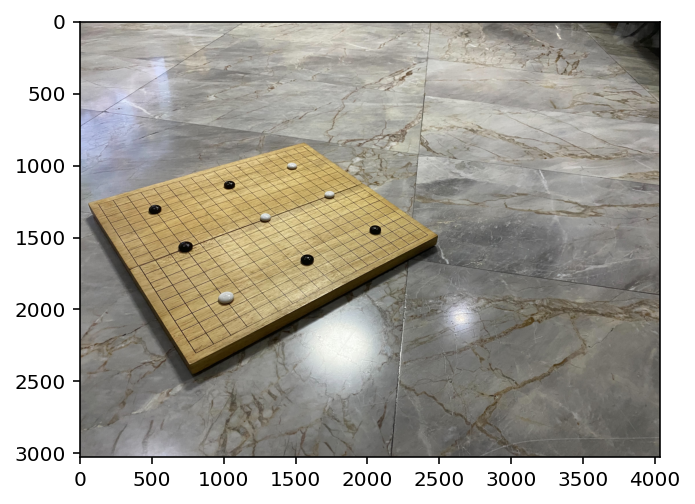

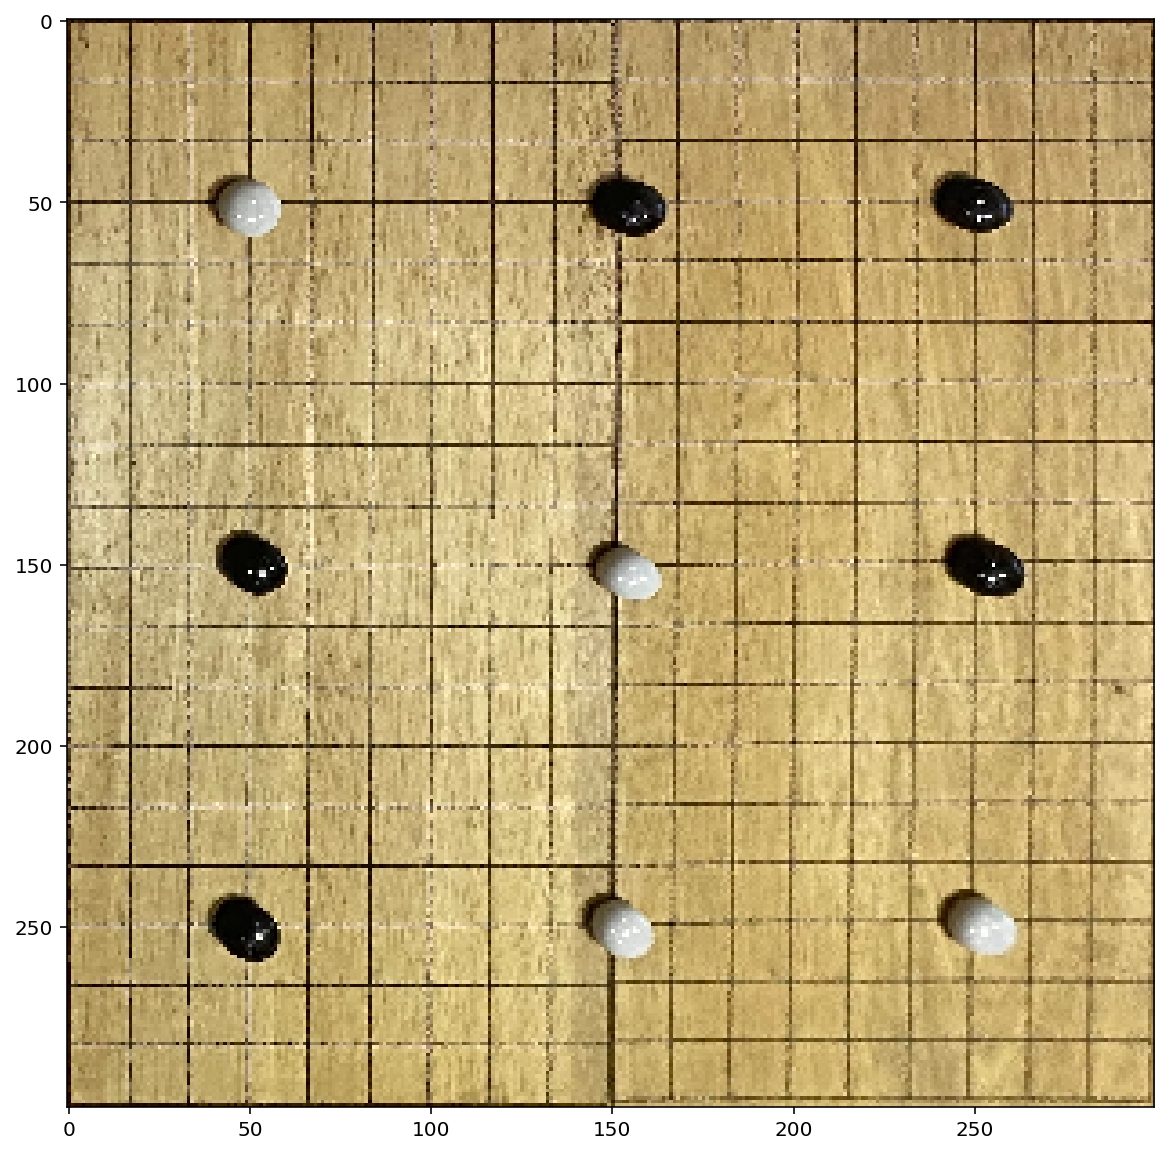

In [10]:
from scipy.interpolate import interp2d, interpn
def interp_map(cm, im, x_min, x_max, z_min, z_max, nx, nz):
    points = np.array([[x,0,z] for x in np.linspace(x_min, x_max, nx) for z in np.linspace(z_min, z_max, nz)]).T
    u = cm.project(points)
    #print(im[([1,2],[2,3],[3,5])])
    #TODO: check some bound etc
    u = np.rint(u).astype(int)
    rgbs = im[u[1], u[0]] # not typo
    
    print(u[0], u[1])
    #target = np.zeros((nx,nz,3), dtype=int)
    target = rgbs.reshape(nx,nz,3)
    return target
    
    
#     print(rgbs[:,0].shape, points.shape)
#     r = interp2d(x=points[0], y=points[2], z=rgbs[:,0])
#     x = np.linspace(x_min, x_max, nx)
#     z = np.linspace(z_min, z_max, nz)
#     xx, zz = np.meshgrid(x, z)
#     r(xx.ravel(),zz)
    
    
a = interp_map(cm, pyplotim2, 0, 18, 0, 18, 300, 300)

plt.imshow(pyplotim2)
plt.figure(figsize=(10,10))
plt.imshow(a) # image is mirror though. New fix it for me please
#print(a)
#b = pyplotim2.copy()
#b[800:920, 2280:2510] = [255, 0, 0]
#plt.imshow(b)

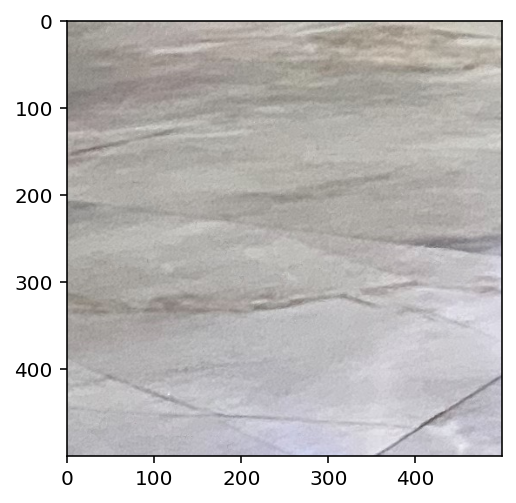

In [11]:
from scipy.ndimage import geometric_transform

def mapping(xz):
    x,z,c = xz
    
    return x, z, c
got = geometric_transform(pyplotim2, mapping, output_shape=(500,500,3))

plt.imshow(got)

In [12]:
pyplotim2.shape

(3024, 4032, 3)

In [13]:
# destination at x, z =
# --> dest
# xw = R.T @ (k*(u-c) - s.t))
# = R.T@u

In [14]:

def show(tx, ty, tz, f, alpha, beta, gamma):
    
    cm = Camera.standard()
    cm.t = vec([tx, ty, tz])
    cm.alpha = np.radians(alpha)
    cm.beta = np.radians(beta)
    cm.gamma = np.radians(gamma)
    cm.f_prime = f
    plt.imshow(pyplotim2)
    plt.autoscale(False)
    visualize(cm.project(x_z_plane), color='green', marker='.', linestyle='')
    #visualize(cm.project(x_y_plane), color='red', marker='.', linestyle='')
    #visualize(cm.project(y_z_plane), color='blue', marker='.', linestyle='')
    #visualize(cm.project(ORIGIN), color='magenta', marker='x', linestyle='')
    print(cm.project(ORIGIN))
    #plt.axis('scaled')

    plt.grid()
    plt.show()
interactive_plot = interactive(show, 
                               tx=pan_slider(),
                               ty=pan_slider(),
                               tz=pan_slider(value=10),
                               f=zoom_slider(),
                               alpha=angle_slider(), 
                               beta=angle_slider(), 
                               gamma=angle_slider())
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='tx', max=30, min=-10), IntSlide…